In [5]:
import ast
import os
import keras
from keras.layers import Dense, Embedding, Input
from keras.layers import GRU, Dropout, MaxPooling1D, Conv1D, Flatten, LSTM
from keras.models import Model
import numpy as np
import itertools
from keras.utils import np_utils, Sequence
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score
from sklearn import preprocessing
from keras.preprocessing import text, sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from plot_util import plot_confusion_matrix
import time
import h5py
%matplotlib inline

# Model parameters
MAX_FEATURES = 256404
MAX_TEXT_LENGTH = 2000
EMBED_SIZE  = 300
BATCH_SIZE = 64
EPOCHS = 2
VALIDATION_SPLIT = 0.1

Nous définissons la fonction pour lire le jeu de données et faire le découpage d'apprentissage et test. 

In [6]:
def split_datasets(data_paths, test_size):
    x = []
    y = []
    for data_path in data_paths:
        with open(data_path, 'r') as f:
            for line in f:
                temp = line.split('__label__')
                x.append(temp[0])
                y.append(temp[1].replace('\n', ''))
            
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
    print('Dataset splited.')
    return x_train, x_test, y_train, y_test

Pour construire le pipeline, nous allons d'abord définir des fonctions pour pré-traiter les données.

Nous allons tokenizer les données et nous mettrons les données et les labels au format propre pour le réseau de neurones. Les labels seront transmis aux vecteurs one-hot. Les données seront tokenizées et mises à la même longueur. Nous coupons les exemples trop longs et nous utilisons zero-padding pour les exemples courts.

In [23]:
def get_train_test(train_raw_text, test_raw_text):
    
    tokenizer = text.Tokenizer(num_words=MAX_FEATURES)

    tokenizer.fit_on_texts(list(train_raw_text))
    word_index = tokenizer.word_index
    train_tokenized = tokenizer.texts_to_sequences(train_raw_text)
    test_tokenized = tokenizer.texts_to_sequences(test_raw_text)
    return sequence.pad_sequences(train_tokenized, maxlen=MAX_TEXT_LENGTH), \
           sequence.pad_sequences(test_tokenized, maxlen=MAX_TEXT_LENGTH), \
           word_index


def class_str_2_ind(x_train, x_test, y_train, y_test):
    print('Converting data to trainable form...')
    le = preprocessing.LabelEncoder()
    n_out = len(CLASSES_LIST)
    le.fit(CLASSES_LIST)
    y_train = le.transform(y_train)
    y_test = le.transform(y_test)
    train_y_cat = np_utils.to_categorical(y_train, n_out)
    x_vec_train, x_vec_test, word_index = get_train_test(x_train, x_test)
    print('Number of training examples: ' + str(len(x_vec_train)))
    print('Number of test examples: ' + str(len(x_vec_test)))
    
    return x_vec_train, x_vec_test, y_train, y_test, train_y_cat, word_index

Nous définissons la fonction pour lire les vecteurs de mots pré-appris. Nous construissons aussi la matrice d'entrée depuis x_train et les vecteurs de mots. Cette partie est basé sur le [tutoriel de Keras](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html) 

In [8]:
def get_embedding_index(vectors_file_path):
    embeddings_index = {}
    with open(vectors_file_path, 'r') as f:
        first_line = f.readline()
        #print(first_line)
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
            
    print('Found %s word vectors.' % len(embeddings_index))
    
    return embeddings_index


def get_embedding_matrix(word_index, embedding_index):
    print('Building embedding matrix...')
    embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    print('Embedding matrix built.')        
    return embedding_matrix

Nous définissons un modèle de classification de texte avec une couche de Conv1D et une couche de Dense. Nous pouvons utiliser les vecteurs de mots pré-appris. Le modèle est basé sur le [TP de M. Kermorvant](https://gitlab.com/kermorvant/nlp-labs) et https://github.com/gaussic/text-classification-cnn-rnn.

In [35]:
def get_model(embedding_matrix, word_index, print_sum=True):

    inp = Input(shape=(MAX_TEXT_LENGTH,))

    model = Embedding(len(word_index) + 1,
                      EMBED_SIZE,
                      weights=[embedding_matrix],
                      input_length=MAX_TEXT_LENGTH,
                      trainable=False)(inp)
    
    #model = Dropout(0.2)(model)
    model = Conv1D(filters=32, kernel_size=5, padding='same', activation='relu')(model)
    model = Dropout(0.5)(model)
    model = MaxPooling1D(pool_size=2)(model)
    #model = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(model)
    #model = Dropout(0.5)(model)
    #model = MaxPooling1D(pool_size=2)(model)
    model = Flatten()(model)
    model = Dense(512, activation='relu')(model)
    model = Dropout(0.5)(model)
    model = Dense(11, activation="softmax")(model)
    model = Model(inputs=inp, outputs=model)
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    if print_sum:
        model.summary()
    return model


def train_fit_predict(model, x_train, x_test, y_train):
    
    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS, verbose=1)

    return model.predict(x_test)

Nous plottons la matrice de confusion, code basé sur [l'exemple de sklearn](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html).

In [10]:
def plot_conf_mat(y_test, y_predicted):
    conf_mat = confusion_matrix(y_test, y_predicted)
    plt.figure(figsize=(10,10))
    plt.subplot(121)
    plot_confusion_matrix(conf_mat, CLASSES_LIST, title='Confusion matrix, without normalization')
    plt.subplot(122)
    plot_confusion_matrix(conf_mat, CLASSES_LIST, normalize=True, title='Normalized confusion matrix')

Nous construissons le pipeline pour evaluer la qualité des vecteurs de mots.

In [11]:
def evaluation(vectors_file_path, print_sum=True, plot_mat=True):
    embedding_index = get_embedding_index(vectors_file_path)
    embedding_matrix = get_embedding_matrix(word_index, embedding_index)
    print('Building model...')
    model = get_model(embedding_matrix, word_index, print_sum=print_sum)
    y_predicted = train_fit_predict(model, x_vec_train, x_vec_test, train_y_cat).argmax(1)
    print("Test Accuracy:", accuracy_score(y_test, y_predicted))
    if plot_mat:
        plot_conf_mat(y_test, y_predicted)
    return accuracy_score(y_test, y_predicted)

Maintenant, nous allons lire le jeu de données *[news_fastexttext_test.txt](https://drive.google.com/open?id=1psrAH5heISv3t2xuB4YKxUCvsUN6yU6C)* et *[news_less_category.txt](https://drive.google.com/open?id=11kUgD4HhqRqhEhS_6yTx_QOXKCWGF3U8)*, puis faire le découpage afin d'obtenir le jeu de données d'apprentissage utilisé et le jeu de données de test utilisé.

In [12]:
data_paths = ['datasets/news_less_category.txt', 'datasets/news_fasttext_test.txt']
test_size = 0.1
x_train, x_test, y_train, y_test = split_datasets(data_paths, test_size)
CLASSES_LIST = np.unique(y_train)
print('Label categories: ' + str(CLASSES_LIST))
x_vec_train, x_vec_test, y_train, y_test, train_y_cat, word_index = class_str_2_ind(x_train, x_test, y_train, y_test)

Dataset splited.
Label categories: ['affairs' 'economic' 'edu' 'ent' 'fashion' 'game' 'home' 'house'
 'science' 'sports' 'stock']
Converting data to trainable form...
Number of training examples: 192022
Number of training examples: 21336


D'abord, nous faisons un exemple d'évaluations en utilisant *word2vec_skip*.

In [36]:
vectors_file_path = '/home/chenxin/WordEmbedding/pre_trained_vectors/raw_300/ft_pure_cbow_300.vec'
embedding_index = get_embedding_index(vectors_file_path)
embedding_matrix = get_embedding_matrix(word_index, embedding_index)
print('Building model...')
model = get_model(embedding_matrix, word_index)
y_predicted = train_fit_predict(model, x_vec_train, x_vec_test, train_y_cat).argmax(1)
print("Test Accuracy:", accuracy_score(y_test, y_predicted))
plot_conf_mat(y_test, y_predicted)

Found 182712 word vectors.
Building embedding matrix...
Embedding matrix built.
Building model...


ValueError: Fetch argument <tf.Variable 'embedding_2/embeddings:0' shape=(499368, 300) dtype=float32_ref> cannot be interpreted as a Tensor. (Tensor Tensor("embedding_2/embeddings:0", shape=(499368, 300), dtype=float32_ref) is not an element of this graph.)

Nous allons évaluer la performance de chaque méthode.

In [10]:
# methods = ['pre_trained_vectors/fasttext_skip.vec',
#            'pre_trained_vectors/fasttext_cbow.vec',
#            'pre_trained_vectors/word2vec_skip.txt',
#            'pre_trained_vectors/word2vec_cbow.txt',
#            'pre_trained_vectors/glove.txt']
methods = ['pre_trained_vectors/raw_300/ft_pure_skipgram_300.vec',
           'pre_trained_vectors/raw_300/ft_pure_cbow_300.vec']
accuracies = {}
for vector_file in methods:
    acc = evaluation(vector_file, print_sum=False, plot_mat=False)
    method = vector_file.split('/')[1].split('.')[0]
    accuracies[method] = acc
print()
print('========================================================')
for meth, acc in accuracies.items():
    print('Test Accuracy of %s: %f' % (meth, acc))

Found 182711 word vectors.
Building embedding matrix...
Embedding matrix built.
Building model...
Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
Epoch 1/2
192022/192022 [==============================] - 26s 136us/step - loss: 0.2891 - acc: 0.9149
Epoch 2/2
192022/192022 [==============================] - 25s 131us/step - loss: 0.1714 - acc: 0.9492
Test Accuracy: 0.9468972628421447
Found 182712 word vectors.
Building embedding matrix...
Embedding matrix built.
Building model...
Epoch 1/2
192022/192022 [==============================] - 26s 135us/step - loss: 0.4242 - acc: 0.8829
Epoch 2/2
192022/192022 [==============================] - 25s 132us/step - loss: 0.2367 - acc: 0.9306
Test Accuracy: 0.9368672665916761

Test Accuracy of raw_300: 0.936867


Les résultats nous ont montrés que la méthode SkipGram a eu une meilleur performance, avec n'import quelle méthode. Au contraire, CBOW n'est pas assez performant. GloVe est presque pareil que CBOWs.

In [17]:
import tensorflow as tf
import os
import sys
import json
import gc

sys.path.append("..")
    
from bilm_tf.bilm import TokenBatcher, BidirectionalLanguageModel, \
weight_layers, dump_token_embeddings


raw_context = []
with open("datasets/news_less_category.txt", "r") as f:
    for line in f:
        temp = line.split('__label__')
        raw_context.append(temp[0])
        
# We only use the part with MAX_TEXT_LENGTH in each sentence(line)
tokenized_context = [sentence.split()[:MAX_TEXT_LENGTH] for sentence in raw_context]
#tokenized_context = [sentence.split() for sentence in raw_context]
max_length = len(tokenized_context[0])
max_line = 0
lens = []
for i in range(len(tokenized_context)):
    length = len(tokenized_context[i])
    lens.append(length)
    if length > max_length:
        max_length = length
        max_line = i
print(max_length)
print(max_line)
print(len(tokenized_context))
# del(lens)
# del(raw_context)
gc.collect()

2000
62
109989


0

109989


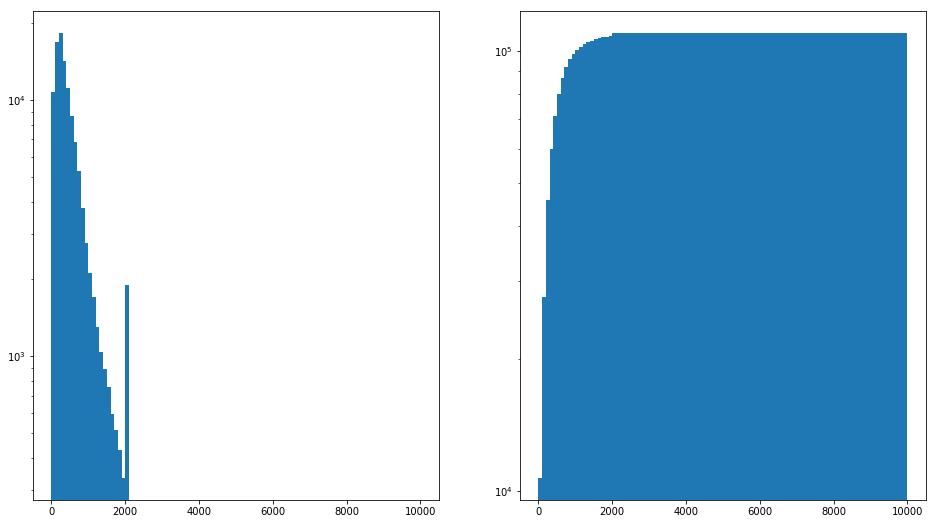

In [18]:
plt.figure(figsize=(16,9))
plt.subplot(121)
plt.hist(lens, bins=100, range=(0, 10000))
plt.yscale('log')
plt.subplot(122)
plt.hist(lens, bins=100, range=(0, 10000), cumulative=True)
plt.yscale('log')
print(len(lens))

In [19]:
def dump_vectors(elmo_embedding, prefix, shard_num, dump_batch, nb_batch):
    elmo_vectors = np.zeros((dump_batch * nb_batch, MAX_TEXT_LENGTH, elmo_embedding[0].shape[2]))
    print(elmo_vectors.shape)
    for i in range(elmo_vectors.shape[0]):
        elmo_vectors[i, :elmo_embedding[i//dump_batch].shape[1], :] = elmo_embedding[i//dump_batch][i%dump_batch, :, :]

    #prefix = 'pre_trained_vectors/elmo_600/elmo_vector_'
    outfile = prefix + str(shard_num) + ".hdf5"
    with h5py.File(outfile, 'w') as fout:
        ds = fout.create_dataset(
            'elmo_vectors', elmo_vectors.shape, dtype='float32', data=elmo_vectors)
    del(elmo_vectors)
    gc.collect()

# Define a DataGenerator

In [31]:
class DataGenerator(Sequence):
    """
    Generates data for Keras
    """
    def __init__(self, x, y, n_classes=11, batch_size=64, shuffle=True):
        """
        Initialization
        """
        self.batch_size = batch_size
        self.x = x
        self.y = y
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        """
        Denotes the number of batches per epoch
        """
        return int(np.floor(len(self.x) / self.batch_size))


    def __getitem__(self, index):
        """
        Generate one batch of data
        """
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y
    
    
    def on_epoch_end(self):
        """
        Updates indexes after each epoch
        """
        self.indexes = np.arange(len(self.y))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
            
    def __data_generation(self, indexes):
        """
        Generates data containing batch_size samples, X : (n_samples, *dim)
        """
        y = self.y[indexes]
        with tf.Session(config=config) as sess:
        # It is necessary to initialize variables once before running inference.
            sess.run(tf.global_variables_initializer())

            # Create batches of data.
            elmo_embedding = []
            count = 0
            tic = time.time()
            dump_batch = 64
            print("Start computing...")
            
            context_ids = batcher.batch_sentences(tokenized_context[indexes])
            #print(context_ids.shape)

            # Compute ELMo representations (here for the input only, for simplicity).
            elmo_context_input_ = sess.run(
                [elmo_context_input['weighted_op']],
                feed_dict={context_token_ids: context_ids}
            )
            
        return elmo_context_input_, y
    
    

In [32]:
vocab_file = '/home/chenxin/WordEmbedding/pre_trained_vectors/raw_300/ft_5_vocab.txt'
options_file = '/home/chenxin/ELMo/pure_checkpoint/options.json'
weight_file = '/home/chenxin/ELMo/pure_checkpoint/weights.hdf5'
token_embedding_file = '/home/chenxin/WordEmbedding/pre_trained_vectors/raw_300/vocab_embedding.hdf5'
prefix = 'pre_trained_vectors/elmo_600/elmo_vector_'
with open(options_file, 'r') as fin:
    options = json.load(fin)

tf.reset_default_graph()
## Now we can do inference.
# Create a TokenBatcher to map text to token ids.
batcher = TokenBatcher(vocab_file)

# Input placeholders to the biLM.
context_token_ids = tf.placeholder('int32', shape=(None, None))

# Build the biLM graph.
bilm = BidirectionalLanguageModel(
    options_file,
    weight_file,
    use_character_inputs=False,
    embedding_weight_file=token_embedding_file
)

# Get ops to compute the LM embeddings.
context_embeddings_op = bilm(context_token_ids)
config = tf.ConfigProto(allow_soft_placement=True)

#with tf.variable_scope('', reuse=True):
elmo_context_input = weight_layers('input', context_embeddings_op, l2_coef=0.0)

#with tf.variable_scope('', reuse=True):
elmo_context_output = weight_layers('output', context_embeddings_op, l2_coef=0.0)   

x_train, x_test, y_train, y_test = split_datasets(["datasets/news_less_category.txt"], 0.1)
x_vec_train, x_vec_test, y_train, y_test, train_y_cat, word_index = class_str_2_ind(x_train=x_train, x_test=x_test,\
                                                                                    y_train=y_train, y_test=y_test)
# Parameters
params = {'batch_size': 64,
          'n_classes': 11,
          'shuffle': True}


# Generators
training_generator = DataGenerator(x_vec_train, y_train, **params)
test_generator = DataGenerator(x_vec_test, y_test, **params)

USING SKIP CONNECTIONS
Dataset splited.
Converting data to trainable form...
Number of training examples: 98990
Number of test examples: 10999


In [33]:
inp = Input(shape=(MAX_TEXT_LENGTH, 600))

#model = Dropout(0.2)(model)
model = Conv1D(filters=32, kernel_size=5, padding='same', activation='relu')(inp)
model = Dropout(0.5)(model)
model = MaxPooling1D(pool_size=2)(model)
#model = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(model)
#model = Dropout(0.5)(model)
#model = MaxPooling1D(pool_size=2)(model)
model = Flatten()(model)
model = Dense(512, activation='relu')(model)
model = Dropout(0.5)(model)
model = Dense(11, activation="softmax")(model)
model = Model(inputs=inp, outputs=model)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
    
model.fit_generator(training_generator, use_multiprocessing=True)
y_pred = model.predict_generator(test_generator).argmax(1)
print("Test Accuracy:", accuracy_score(y_test, y_predicted))
plot_conf_mat(y_test, y_predicted)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2000, 600)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2000, 32)          96032     
_________________________________________________________________
dropout_1 (Dropout)          (None, 2000, 32)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1000, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               16384512  
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

KeyboardInterrupt: 

In [5]:
vocab_file = '/home/chenxin/WordEmbedding/pre_trained_vectors/raw_300/ft_5_vocab.txt'
options_file = '/home/chenxin/ELMo/pure_checkpoint/options.json'
weight_file = '/home/chenxin/ELMo/pure_checkpoint/weights.hdf5'
token_embedding_file = '/home/chenxin/WordEmbedding/pre_trained_vectors/raw_300/vocab_embedding.hdf5'
prefix = 'pre_trained_vectors/elmo_600/elmo_vector_'
with open(options_file, 'r') as fin:
    options = json.load(fin)

tf.reset_default_graph()
## Now we can do inference.
# Create a TokenBatcher to map text to token ids.
batcher = TokenBatcher(vocab_file)

# Input placeholders to the biLM.
context_token_ids = tf.placeholder('int32', shape=(None, None))

# Build the biLM graph.
bilm = BidirectionalLanguageModel(
    options_file,
    weight_file,
    use_character_inputs=False,
    embedding_weight_file=token_embedding_file
)

# Get ops to compute the LM embeddings.
context_embeddings_op = bilm(context_token_ids)
config = tf.ConfigProto(allow_soft_placement=True)

#with tf.variable_scope('', reuse=True):
elmo_context_input = weight_layers('input', context_embeddings_op, l2_coef=0.0)

#with tf.variable_scope('', reuse=True):
elmo_context_output = weight_layers('output', context_embeddings_op, l2_coef=0.0)


with tf.Session(config=config) as sess:
    # It is necessary to initialize variables once before running inference.
    sess.run(tf.global_variables_initializer())

    # Create batches of data.
    elmo_embedding = []
    count = 0
    tic = time.time()
    dump_batch = 64
    print("Start computing...")
    for i in range(0, len(tokenized_context), dump_batch):
        context_ids = batcher.batch_sentences(tokenized_context[i:i+dump_batch])
        #print(context_ids.shape)

        # Compute ELMo representations (here for the input only, for simplicity).
        elmo_context_input_ = sess.run(
            [elmo_context_input['weighted_op']],
            feed_dict={context_token_ids: context_ids}
        )
        elmo_embedding += elmo_context_input_
        count += 1
            
        if count % 30 == 0:
            dump_vectors(elmo_embedding, prefix, count // 30, dump_batch, 30)
            toc = time.time()
            print("Batch number: " + str(count))
            print("Total time: " + str(toc - tic) + "s")
            del(elmo_embedding)
            gc.collect()
            elmo_embedding = []

USING SKIP CONNECTIONS
Instructions for updating:
Use the `axis` argument instead
Start computing...
(1920, 2000, 600)
Batch number: 30
Total time: 128.10360074043274s
(1920, 2000, 600)
Batch number: 60
Total time: 266.5128540992737s
(1920, 2000, 600)
Batch number: 90
Total time: 403.8405010700226s
(1920, 2000, 600)
Batch number: 120
Total time: 542.5585525035858s
(1920, 2000, 600)
Batch number: 150
Total time: 680.9262328147888s
(1920, 2000, 600)
Batch number: 180
Total time: 808.8398036956787s
(1920, 2000, 600)
Batch number: 210
Total time: 954.7504844665527s
(1920, 2000, 600)
Batch number: 240
Total time: 1082.4198455810547s
(1920, 2000, 600)
Batch number: 270
Total time: 1213.3511128425598s
(1920, 2000, 600)
Batch number: 300
Total time: 1359.203447818756s
(1920, 2000, 600)
Batch number: 330
Total time: 1493.5101065635681s
(1920, 2000, 600)
Batch number: 360
Total time: 1631.0171480178833s
(1920, 2000, 600)
Batch number: 390
Total time: 1765.742110490799s
(1920, 2000, 600)
Batch nu

In [6]:
f = h5py.File('/home/jitao/WordEmbedding/pre_trained_vectors/elmo_600/elmo_vector_1.hdf5', 'r')
vector1 = f['elmo_vectors'][0]
print(vector1)

[[ 0.02679283  0.14638782 -0.20909283 ... -0.317909   -0.36457983
  -1.0772837 ]
 [ 0.11242183  0.17796426 -0.08126539 ...  0.01473063 -0.2738471
  -0.97115237]
 [ 0.0379664  -0.11325606 -0.05286891 ... -0.3455569  -0.24749027
  -1.0140477 ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
